In [176]:
import numpy as np
import pandas as pd
import pylab
import math
%matplotlib inline

## Метод прогонки
На вход подается трехдиагональная матрица, поэтому СЛАУ $Ax = d$ можно предстваить в виде n уравнений (n -- это размерность матрицы):
$$A_i x_{i-1} + C_i x_i + B_i x_{i+1} = D_i$$
$A_1 = 0$ и $B_n = 0$
Поэтому из первого уравнения можно выразить $x_2$ через $x_1$.

Получается $x_{i}=a_{i+1}x_{i+1}+b _{i+1},$   где $i=n-1,n-2,\dots ,1$

Из СЛАУ получается, что эти линейные коэффициенты находятся по формулам:
$a_{i+1} = \frac{-B_i}{A_i a_i + C_i} \\
b_{i+1} = \frac{D_i - A_i b_i}{A_i a_i + C_i}$

И для первого:
$a _{1}={\frac {-B_{1}}{C_{1}}}\\
b _{1}={\frac {D_{1}}{C_{1}}}$

Последовательно вычисляя $a_{i}$ и $b_{i}$, получим $x_n = b_n$.

Далее обратным шагом найдем все остальные переменные последовательной подстановкой в найденные линейные зависмости.

In [177]:
def LinSys(A, b):
    m = len(b)-1
    Ar = [[-A[0][1]/A[0][0], b[0]/A[0][0]]]
    for i in range(1, m):
        Ar.append([-A[i][i+1]/(A[i][i]+A[i][i-1]*Ar[-1][0]),
                   (b[i]-A[i][i-1]*Ar[-1][1])/(A[i][i]+A[i][i-1]*Ar[-1][0])])
    ans = [(b[m]-A[m][m-1]*Ar[-1][1])/(A[m][m]+A[m][m-1]*Ar[-1][0])]
    for i in reversed(range(m)):
        ans.append(Ar[i][0]*ans[-1]+Ar[i][1])
    return np.array(ans[::-1])

Из-за последовательного вычисления ошибка округления накапливается, поэтому для матриц больших размерностей, она будет больше.
Достаточное условие приминимости метода прогонки -- это диагональное преобладание.
Рассмотрим три соответсвующих примера.

In [178]:
def get_tr_matrix(n, a, b):
    A = [[0 for i in range(n)] for i in range(n)]
    A[0][0] = a
    A[0][1] = b
    A[-1][-1] = a
    A[-1][n-2] = b
    for i in range(n -2):
        A[i+1][i] = b
        A[i+1][i+2] = b
        A[i+1][i+1] = a
    return A

In [179]:
matrices = [get_tr_matrix(3, 10**3, 1), get_tr_matrix(8, 10**3, 1), get_tr_matrix(8, 1, 10**3)]
for matrix in matrices :
    print(np.array(matrix))

[[1000    1    0]
 [   1 1000    1]
 [   0    1 1000]]
[[1000    1    0    0    0    0    0    0]
 [   1 1000    1    0    0    0    0    0]
 [   0    1 1000    1    0    0    0    0]
 [   0    0    1 1000    1    0    0    0]
 [   0    0    0    1 1000    1    0    0]
 [   0    0    0    0    1 1000    1    0]
 [   0    0    0    0    0    1 1000    1]
 [   0    0    0    0    0    0    1 1000]]
[[   1 1000    0    0    0    0    0    0]
 [1000    1 1000    0    0    0    0    0]
 [   0 1000    1 1000    0    0    0    0]
 [   0    0 1000    1 1000    0    0    0]
 [   0    0    0 1000    1 1000    0    0]
 [   0    0    0    0 1000    1 1000    0]
 [   0    0    0    0    0 1000    1 1000]
 [   0    0    0    0    0    0 1000    1]]


In [180]:
df = pd.DataFrame(columns=['Det', 'Norm', 'Cond'])
df['Det'] = [np.linalg.det(mat) for mat in matrices]
df['Norm'] = [np.linalg.norm(mat) for mat in matrices]
df['Cond'] = [np.linalg.cond(mat) for mat in matrices]

In [181]:
error = []
for mat in matrices:
    b = [i for i in range(len(mat))]
    error.append(np.linalg.norm(np.dot(mat,LinSys(mat, b)) - b))
df['Error'] = error

In [182]:
df

,Det,Norm,Cond,Error
0,9.999980e+08,1732.051962,1.002832,2.220446e-16
1,9.999930e+23,2828.429600,1.003766,1.439014e-15
2,9.999900e+23,3741.658456,5.429989,2.227895e-13


Как и предсказывалось, на небольшой матрице с сильной главной диагональю ошибка меньше, чем на большой. А на ней меньше, чем на матрице того же размера, но без диагонального преобладания.

## Сплайны

Кубическим сплайном дефекта 1 называется функция S(x), которая:

* на каждом отрезке $[x_{i-1},x_{i}]$ является многочленом степени не выше третьей
* имеет непрерывные первую и вторую производные на всём отрезке $[a,b]$
* в точках $x_{i}$ выполняется равенство $S(x_{i})=f(x_{i})$

Эта функция задается на каждом отрезке разбиения $\delta_i = x_{i+1} - x_i$ задается формулой:

$$ S_{i}(x) = \frac{1}{6 \delta_i} \left(m_i(x_{i+1} - x)^3 + m_{i+1}(x - x_{i})^3  \right) + A_{i}x +B_i  $$

где m -- это вектор значений вторых производных. $m[1:n-1]$ можно найти, решив СЛАУ:

$ A = \begin{pmatrix}
\frac{\delta_0+\delta_1}{3} & \frac{\delta_1}{6} & \dots & \dots & 0 \\
\frac{\delta_1}{6} & \frac{\delta_1+\delta_2}{3} & \frac{\delta_2}{6} & \dots & 0 \\
\ddots & \ddots & \ddots & \vdots &\vdots \\
 0 & \dots & \dots & \frac{\delta_{i-2}}{6} & \frac{\delta_{i-2}+\delta_{i-1}}{3} \\
\end{pmatrix}
$

$b = \begin{pmatrix}
\frac{f_2-f_1}{\delta_1} - \frac{f_1-f_0}{\delta_0}\\
\vdots\\
\frac{f_{i+1}-f_i}{\delta_i} - \frac{f_i-f_{i-1}}{\delta_{i-1}}\\
\vdots\\
\end{pmatrix}
$

$Am = b$

Также по предположению $m_0 = m_n = 0$.

Коэффициенты $A_i$ и $B_i$ находятся по формулам:

$A_i = \frac{f_{i+1} - f_i}{\delta_i} - \frac{\delta_i}{6}  \left( m_{i+1} - m_i \right) $

$B_i= f_i - \frac{1}{6}m_i \delta^2 - A_ix_i$

In [183]:
def Interp(x, f, path = ""):
    n = len(x)-1
    teta = [x[i]-x[i-1] for i in range(1, len(x))]
    A = np.zeros((n-1, n-1))
    for i in range(n-2):
        A[i][i] = (teta[i]+teta[i+1])/3
        A[i][i+1] = teta[i+1]/6
        A[i+1][i] = teta[i+1]/6
    A[n-2][n-2] = (teta[n-2]+teta[n-1])/3
    b = np.array([(f[i+1]-f[i])/teta[i] - (f[i]-f[i-1])/teta[i-1] for i in range(1, n)])
    m = np.hstack(([0], np.array(LinSys(A, b)), [0]))
    A = np.zeros(n)
    B = np.zeros(n)
    for i in range(n):
        A[i] = (f[i+1]-f[i])/teta[i] - teta[i]*(m[i+1]-m[i])/6
        B[i] = f[i]-m[i]*teta[i]**2/6 - A[i]*x[i]
    Splain = []
    for i in range(n):
        sp = np.zeros(4)
        sp[0] = (m[i+1]-m[i])/(6*teta[i])
        sp[1] = (m[i]*x[i+1] - m[i+1]*x[i]) / (2*teta[i])
        sp[2] = (m[i+1]*x[i]**2 - m[i]*x[i+1]**2) / (2*teta[i]) + A[i]
        sp[3] = (m[i]*x[i+1]**3 - m[i+1]*x[i]**3) / (6*teta[i]) + B[i]
        Splain.append(sp)
    return Splain

In [184]:
def draw_plot(x, Splain, func, er = False):
    X = np.array([])
    Y = np.array([])
    Y_real = np.array([])
    Error = np.array([])
    for i in range(len(Splain)):
        sp = Splain[i]
        ax = np.linspace(x[i], x[i+1])
        y = sp[0]*ax**3 + sp[1]*ax**2 +sp[2]*ax + sp[3]
        X = np.hstack((X, ax))
        Y = np.hstack((Y, y))
        Y_real = np.hstack((Y_real, func(ax)))
        if er:
            Error = np.hstack((Error, func(ax) - y))
    pylab.plot(X, Y, color='green')
    pylab.plot(x, func(x), 'o', color='red')
    pylab.plot(X, Y_real, color='red')
    pylab.show()
    if er:
        pylab.plot(X, Error, color='blue')
        pylab.show()

## Пример 1

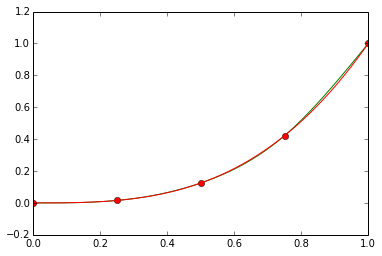

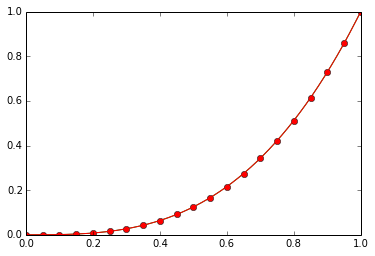

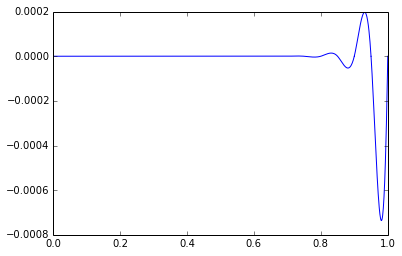

In [185]:
x = np.linspace(0, 1, 5)
x_fr = np.linspace(0, 1, 21)
Splain = Interp(x, x**3)
Splain_fr = Interp(x_fr, x_fr**3)
draw_plot(x, Splain, lambda x: x**3)
draw_plot(x_fr, Splain_fr, lambda x: x**3, True)

## Пример 2

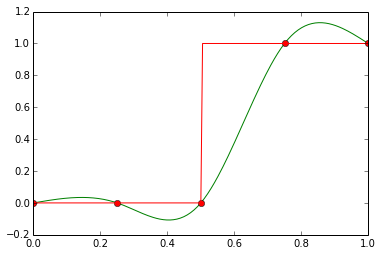

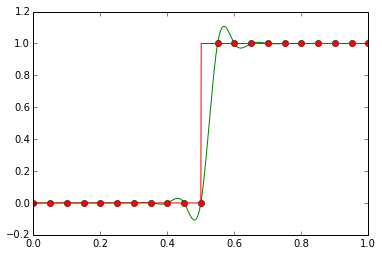

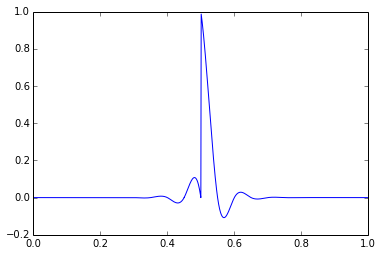

In [186]:
func2 = lambda x: (x>0.5)+0
x = np.linspace(0, 1, 5)
x_fr = np.linspace(0, 1, 21)
Splain = Interp(x, func2(x))
Splain_fr = Interp(x_fr, func2(x_fr))
draw_plot(x, Splain, func2)
draw_plot(x_fr, Splain_fr, func2, True)

## Пример 3

In [187]:
def func3(x):
    return x**(3)*np.cos(100*x)

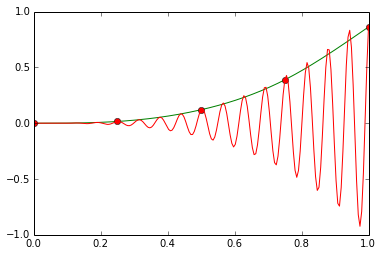

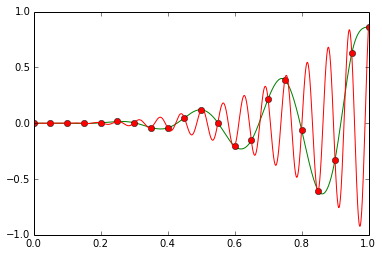

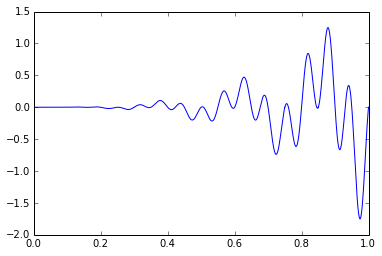

In [189]:
x = np.linspace(0, 1, 5)
x_fr = np.linspace(0, 1, 21)
Splain = Interp(x, func3(x))
Splain_fr = Interp(x_fr, func3(x_fr))
draw_plot(x, Splain, func3)
draw_plot(x_fr, Splain_fr, func3, True)

У сплайнов гладкой и разравной функции ошибка небольшая, а на осциллирующей ошибка предсказуемо большая.